In [1]:
import pytensor
import pytensor.tensor as pt

# Extending Pytensor

In this final section, we're going to go back to "raw" pytensor, and see how the rewrite engine works under the hood.

Our motivating example is going to be a missing optimization from the GP example, the determinant of a lower-triangular matrix.

You might recall this formula for the determinant of a 2x2 matrix from linear algebra:

$$
\det \left (
\begin{bmatrix}
\color{red}{a} & \color{blue}{b} \\
\color{blue}{c} & \color{red}{d}
\end{bmatrix}
\right ) 
= \color{red}{ad} - \color{blue}{bc}
$$

Or for a 3x3:

$$
\det\!\left(
\begin{bmatrix}
\color{red}{a} & \color{blue}{b} & \color{green}{c}\\
d & e & f\\
g & h & i
\end{bmatrix}
\right)
=
\color{red}{a\,(ei - fh)}
\;-\;
\color{blue}{b\,(di - fg)}
\;+\;
\color{green}{c\,(dh - eg)}
$$

Notice in both cases that when the matrix is triangular, the expression simplifies:

$$
\det\!\left(
\begin{bmatrix}
\color{red}{a} & \color{blue}{0} & \color{green}{0}\\
d & e & 0\\
g & h & i
\end{bmatrix}
\right)
=
\color{red}{a\,(ei - 0h)}
\;-\;
\color{blue}{0\,(di - fg)}
\;+\;
\color{green}{0\,(dh - eg)}
= aei
$$

Which is just the product of the main diagonal! This pattern will hold for a matrix of any size.

We can register a rewrite in pytensor to use this formula when possible. 

# Anatomy of a Rewrite

A *rewrite* in Pytensor is just a function with the following signature:

```py
def my_rewrite(fgraph: FunctionGraph, node: Node):
   ...
```

This signature will never change. 

- An `fgraph` is a `FunctionGraph`. It is a class used by Pytensor to represent an intermediate form between a static graph (what the user actually provides) and compiled code (which is static in its own way too!). It is a graph that is ready to be mutated and acted on.
- A `Node` is a class that holds a unit of computation on a Pytensor graph.


## Little Aside About Nodes

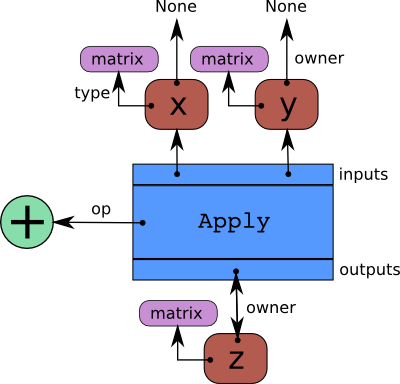

Here is a schematic of an `Apply` `Node`, which is likely the only type of node you will ever need to know about. An `Apply` node has three pieces: `inputs`, `outputs`, and `op`. An `op` is an actual operator, it knows how to do some kind of computation. From the perspective of the the Node, the Op is a black box that just needs some inputs and give some output. 

(The fact that the node is agnostic to the underlying computation is what allows PyTensor to dispatch to different backends)

A computation graph is a bipartate graph, interleaving variables (like `X`, `Y` and `Z` in the schematic) and nodes (the `Apply`)

Note that the graph is read top to bottom, but computation flows upward. `None` "owns" `X` an `Y`, because these are root inputs. In turn, `X` and `Y` are the `inputs` to the `Apply`. The `Apply` owns `Z`, because it creates it.

The actual computation, in this case addition, is contained in the `Op`, but again, we don't need to actually *perform* the computation to know about the relationships between `X`, `Y`, and `Z`.

In [2]:
X = pt.dmatrix('X')
Y = pt.dmatrix('Y')
Z = X + Y
Z.name = 'Z'

In [3]:
Z.owner

Add(X, Y)

In [4]:
type(Z.owner)

pytensor.graph.basic.Apply

In [5]:
Z.owner.op

Elemwise(scalar_op=add,inplace_pattern=<frozendict {}>)

In [6]:
type(Z.owner.op)

pytensor.tensor.elemwise.Elemwise

In [7]:
Z.owner.inputs

[X, Y]

In [8]:
type(Z.owner.inputs[0])

pytensor.tensor.variable.TensorVariable

In [9]:
Z.owner.outputs

[Z]

In [10]:
type(Z.owner.outputs[0])

pytensor.tensor.variable.TensorVariable

## Back to Rewriting

So when you do a rewrite, you want a function that takes a `node` and an `fgraph` and returns a new node.

By the way, in most cases you won't look at the `fgraph`. That is provided in case you need to reason globally about the computation in order to accomplish your rewrite. In simple cases, such as our example here, a "local" replacement will suffice.

Let's start by looking at the structure of the `det` `Node`

In [11]:
X = pt.dmatrix('X')
det_X = pt.linalg.det(X)
det_X.name = 'Det_X'
det_X

Det_X

In [12]:
type(det_X)

pytensor.tensor.variable.TensorVariable

In [13]:
type(det_X.owner)

pytensor.graph.basic.Apply

In [14]:
type(det_X.owner.op)

pytensor.tensor.blockwise.Blockwise

In [15]:
type(det_X.owner.op.core_op)

pytensor.tensor.nlinalg.Det

In [16]:
det_X.owner.inputs

[X]

In [17]:
det_X.owner.outputs

[Det_X]

As a first pass, let's just assume that `X` is always going to be triangular. 

If this is the case, we want a function that:

1. Checks if the incoming node has the op `nlinalg.Det`
2. If not, return None -- this means do not apply a rewrite
3. If yes, extract the diagonal of X and return its product.

In [18]:
from pytensor.tensor.nlinalg import Det

def local_det_to_diag_prod(fgraph, node):
    core_op = node.op.core_op
    if not isinstance(core_op, Det):
        return None
    [X] = node.inputs
    x_diag = pt.diagonal(X, axis1=-1, axis2=-2)
    return pt.prod(x_diag)

In [19]:
local_det_to_diag_prod(None, det_X.owner).dprint()

Prod{axes=None} [id A]
 └─ ExtractDiag{offset=0, axis1=0, axis2=1, view=True} [id B]
    └─ X [id C]


In [20]:
pt.reciprocal

Elemwise(scalar_op=reciprocal,inplace_pattern=<frozendict {}>)

## Registering the rewrite

Great, now how do we make it automatic?

To do this, we have to *register* the rewrite into Pytensor's database of rewrites. 

PyTensor actually has several databases of rewrites, which are applied at different times and in different ways. The most common databases are:

- `canonicalize` has rewrites that put graphs into a "canonical" form, so that downstream rewrites can expect things in a certain fixed way. For example, we can write `1/x` as `1/x`, or `pt.reciprocal(x)`, or `x ** (-1)`. But we don't want to have to deal with all those possibilities, so we just cast everything to, say, `pt.reciprocal(x)`
- `stabilize` includes rewrites that are somehow numerically "superior". For example, we can rewrite `log(1 + x)` to `log1p(x)`, because this special function gives the right answer for very small values of x.
- `specialize` includes rewrites that optimize forms for performance.

We will register our rewrite in `specialize`, because it seems to fit the best.

In [21]:
from pytensor.tensor.rewriting.basic import register_specialize
from pytensor.graph.rewriting.basic import node_rewriter
from pytensor.tensor.rewriting.blockwise import blockwise_of

@register_specialize
@node_rewriter([blockwise_of(Det)])
def local_det_to_diag_prod_naive(fgraph, node):
    [X] = node.inputs
    x_diag = pt.diagonal(X, axis1=-1, axis2=-2)
    return [pt.prod(x_diag)]

In [22]:
from pytensor.ipython import InteractiveRewrite
from pytensor.compile.mode import get_mode

InteractiveRewrite(det_X, 
                   rewrite_options={'include': ('fast_run', ), 
                                    'exclude': ('inplace', 'local_det_to_diag_prod_naive', )})

This is a nice first pass, but note that PyTensor does *not* do input checking for us. If we pass a triangular matrix, we will get the right answer, but a non-triangular matrix will now give the wrong answer.

In [23]:
fn = pytensor.function([X], det_X, mode=get_mode('FAST_RUN').including('local_det_to_diag_prod_naive'))

In [24]:
import numpy as np

X_val = np.random.normal(size=(3, 3))
X_val_tri = np.tril(X_val)

In [25]:
print(fn(X_val_tri), np.linalg.det(X_val_tri))

-2.0772958520552502 -2.07729585205525


In [26]:
print(fn(X_val), np.linalg.det(X_val))

-2.0772958520552502 2.2305073986255755


To fix this, we need to be a bit more thoughtful in the rewrite, by detecting if the input is actually triangular. 

We can think about how a triangular matrix can arise. The user could write it down one element at a time -- in this case we're lost, since we can't inspect the data before we have it.

On the other hand, triangular matrices arise from many different operations. For example, the output of `Cholesky` is always a triangular matrix. As a result, we can check if the input to our function is the output of a `Cholesky` `Op`.

In [27]:
from pytensor.tensor.blockwise import Blockwise
from pytensor.tensor.slinalg import Cholesky


@register_specialize
@node_rewriter([blockwise_of(Det)])
def local_det_to_diag_prod_from_chol(fgraph, node):
    [chol_X_maybe] = node.inputs
    
    if not chol_X_maybe.owner:
        return
    
    if not (isinstance(chol_X_maybe.owner.op, Blockwise) and 
            isinstance(chol_X_maybe.owner.op.core_op, Cholesky)):
        return
    [X] = chol_X_maybe.owner.inputs
    x_diag = pt.diagonal(X, axis1=-1, axis2=-2)
    
    return [pt.prod(x_diag)]

Now if we just pass in `X`, no rewrite will be triggered.

In [28]:
fn = pytensor.function([X], 
                       pt.linalg.det(X), 
                       mode=get_mode('FAST_RUN').excluding('local_det_to_diag_prod_naive'))

In [29]:
fn.dprint()

Det [id A] 0
 └─ X [id B]


On the other hand, if we pass in `chol(X)`, we get the rewrite

In [30]:
fn = pytensor.function([X], 
                       pt.linalg.det(pt.linalg.cholesky(X)), 
                       mode=get_mode('FAST_RUN').excluding('local_det_to_diag_prod_naive'))

Notice that the `Cholesky` is completely gone. We don't need to do that at all -- we're just computing the determinant anyway!

In [31]:
fn.dprint()

Prod{axes=None} [id A] 1
 └─ ExtractDiag{offset=0, axis1=0, axis2=1, view=True} [id B] 0
    └─ X [id C]


Of course, there are other ways that a triangular matrix could arise. It could be from a `triu` or `tril` `Op`, or from `QR`, or from `LU`. You could keep expanding the rewrite to include those cases.

Actually, this situation is common enough that we are adding a helper function in [#1612](https://github.com/pymc-devs/pytensor/pull/1612) to check if a symbolic variable can be determined to be triangular from it's graph!